In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import os
import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.use('ggplot')
%pylab inline --no-import-all

#有効数字2桁
%precision 3

#風力発電初期値
Pr=2.3 #定格電力
V_CIN=2.5 #カットイン風速
V_rat=20 #
V_CO=20 #カットアウト風速
H=30.5 #高さ
H_top=80 #風速計測の高さ（高い）
H_ref=10 #風速計測の高さ（低い）
atm_pre0=1.225 #基準大気圧
total_cost = 1575000 #コスト[yen/unit]
Op_year = 10 #稼動年数
cost = (total_cost/(Op_year*365*24)) #コスト[yen/hour/unit]

#インプットデータ
input_data = pd.read_csv('hakata_ekimae_2017_data_from_meteoblue.csv')
#temp = temp.drop("気温(℃).1",axis=1)
#temp = temp.drop("気温(℃).2" ,axis=1)

#列名の変更
input_data.columns = ['Year', 'Month', 'Day','Hour', 'Minute','Temperature(2m)', 'Mean Sea Level Pressure[hpa]', \
                      'Shortwave Radiation[W/m2]','Wind Speed(10m)[m/s]','Wind Direction(10m)' ,'Wind Speed(80m)[m/s]'\
              , 'Wind Direction(80m)']

#日付型などの変更
input_data['Date'] = input_data[['Year', 'Month', 'Day']].apply(lambda x: '{}@{}@{}'.format(x[0], x[1], x[2]), axis=1)
Date = input_data['Date']
input_data['Date'] =pd.to_datetime(Date, format='%Y@%m@%d')

input_data['Time'] = input_data[['Year', 'Month', 'Day','Hour']].apply(lambda x: '{}@{}@{}@{}'.format(x[0], x[1], x[2],x[3]), axis=1)
Time = input_data['Time']
input_data['Time'] =pd.to_datetime(Time, format='%Y@%m@%d@%H')

    #列の順番変更
    #lst = input_data.columns.tolist()
    #lst.remove('Date')
    #lst.remove('Time')
    #lst.insert(0, 'Time')
    #lst.insert(1, 'Date')


Populating the interactive namespace from numpy and matplotlib


In [2]:
V_COE = np.log(input_data['Wind Speed(80m)[m/s]']/input_data['Wind Speed(10m)[m/s]'])\
    /np.log(H_top/H_ref)


input_data['V_COE[power law]']=V_COE
input_data['ρ(air dencity)']=input_data['Mean Sea Level Pressure[hpa]'] / (2.87*273.15+2.87*input_data['Temperature(2m)'])
input_data['Wind Speed('+str(H)+')[m/s]']=input_data['Wind Speed(10m)[m/s]'] *(H / H_ref)**V_COE

/home/yuichiro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [3]:
wind30_values =input_data['Wind Speed('+str(H)+')[m/s]']

Pwt=(np.where((V_rat<=wind30_values) & (wind30_values <= V_CO), Pr,\
              np.where((V_CIN<=wind30_values) & (wind30_values <= V_rat), \
                       Pr*(wind30_values-V_CIN)/(V_rat-V_CIN),0 )))
#Pwt_STP
Pwt_STP=(atm_pre0/input_data['ρ(air dencity)'].values)*Pwt

input_data['Pwt[kW]']= pd.Series(Pwt)
input_data['Pwt_STP[kW]']= pd.Series(Pwt_STP)

#よく使う列だけ表示
dis = input_data.columns.tolist()
dis = ['Time','Pwt', 'Temperature(2m)','Wind Speed('+str(H)+')[m/s]', 'Mean Sea Level Pressure[hpa]','ρ(air dencity)',\
       'Shortwave Radiation[W/m2]', 'Wind Speed(10m)[m/s]',\
       'Wind Speed(80m)[m/s]','V_COE[power law]','Pwt_STP']

input_data.to_csv('Wind_result.csv',encoding="shift_jis")   

/home/yuichiro/miniconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<Figure size 20000x8000 with 0 Axes>

/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


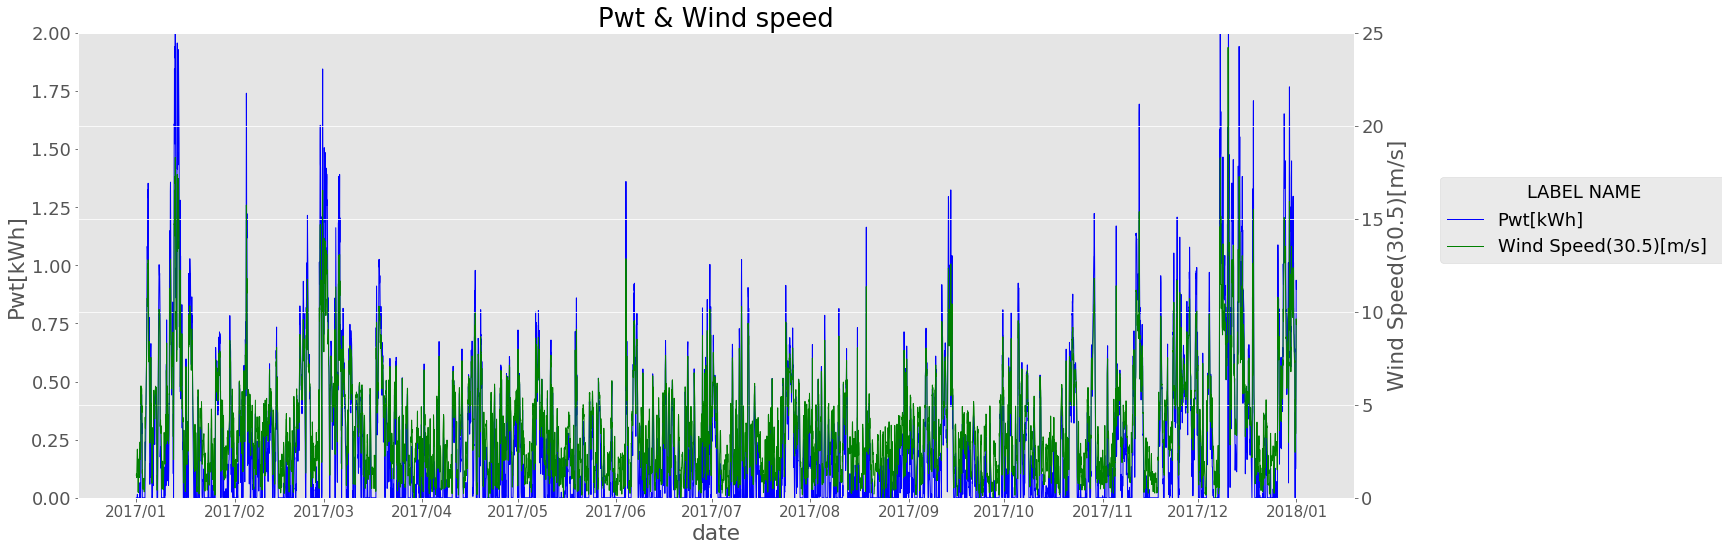

In [4]:
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18


input1 = input_data['Time']
output1 = input_data['Pwt[kW]']
output2 = input_data['Wind Speed('+str(H)+')[m/s]']

fig = plt.figure(figsize=(50,20),dpi=400)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(input1, output1, color='blue',linestyle='solid', linewidth = 1, label='Pwt[kWh]')

ax1.set_ylim([0, 2])
ax2 = ax1.twinx()
ax2.plot(input1, output2, color='green', linewidth = 1, label='Wind Speed('+str(H)+')[m/s]')
ax1.set_title('Pwt & Wind speed')
ax1.set_xlabel('date')
ax1.set_ylabel('Pwt[kWh]')
ax1.set_xticklabels(input1,rotation=0, size="small")
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


days      = mdates.MonthLocator()  # every day
#daysFmt = mdates.DateFormatter('%Y-%m-%d')
daysFmt = mdates.DateFormatter('%Y/%m')
ax1.xaxis.set_major_locator(days)
ax1.xaxis.set_major_formatter(daysFmt)

ax2.set_ylabel('Wind Speed('+str(H)+')[m/s]')
ax2.set_ylim([0, 25])


# 凡例をまとめて出力する
fig.legend(loc="lower right",
           bbox_to_anchor=(1, 0.5, 0.2, .100), 
           borderaxespad=0.,
           ncol=1,
           mode="expand",
           title="LABEL NAME"
          ) 

ax1.grid(False) #目盛のごちゃごちゃ変更

fig.show()

In [5]:
input_data[:10]

,Year,Month,Day,Hour,Minute,Temperature(2m),Mean Sea Level Pressure[hpa],Shortwave Radiation[W/m2],Wind Speed(10m)[m/s],Wind Direction(10m),Wind Speed(80m)[m/s],Wind Direction(80m),Date,Time,V_COE[power law],ρ(air dencity),Wind Speed(30.5)[m/s],Pwt[kW],Pwt_STP[kW]
0,2017,1,1,0,0,3.38,1031.9,0.00,1.66,122.74,0.92,139.40,2017-01-01,2017-01-01 00:00:00,-0.283826,1.300210,1.209626,0.000000,0.000000
1,2017,1,1,1,0,3.39,1031.1,0.00,1.78,128.16,1.00,143.13,2017-01-01,2017-01-01 01:00:00,-0.277292,1.299155,1.306554,0.000000,0.000000
2,2017,1,1,2,0,3.45,1029.9,0.00,1.57,116.57,1.03,119.05,2017-01-01,2017-01-01 02:00:00,-0.202707,1.297361,1.252359,0.000000,0.000000
3,2017,1,1,3,0,2.98,1030.2,0.00,1.80,109.44,0.70,180.00,2017-01-01,2017-01-01 03:00:00,-0.454190,1.299948,1.084697,0.000000,0.000000
4,2017,1,1,4,0,2.49,1029.9,0.00,1.88,115.20,1.26,198.43,2017-01-01,2017-01-01 04:00:00,-0.192436,1.301880,1.516914,0.000000,0.000000
5,2017,1,1,5,0,2.25,1028.8,0.00,2.18,105.95,1.34,153.43,2017-01-01,2017-01-01 05:00:00,-0.234032,1.301623,1.679249,0.000000,0.000000
6,2017,1,1,6,0,1.89,1028.5,0.00,2.31,107.65,1.92,152.10,2017-01-01,2017-01-01 06:00:00,-0.088929,1.302946,2.091914,0.000000,0.000000
7,2017,1,1,7,0,1.65,1028.1,0.00,2.46,116.57,2.64,150.52,2017-01-01,2017-01-01 07:00:00,0.033960,1.303577,2.554947,0.007222,0.006786
8,2017,1,1,8,0,1.75,1028.2,20.47,2.56,120.58,2.66,145.71,2017-01-01,2017-01-01 08:00:00,0.018427,1.303230,2.613150,0.014871,0.013979
9,2017,1,1,9,0,2.12,1027.3,136.17,2.42,114.44,2.48,139.90,2017-01-01,2017-01-01 09:00:00,0.011778,1.300339,2.451993,0.000000,0.000000


<Figure size 3600x1440 with 0 Axes>

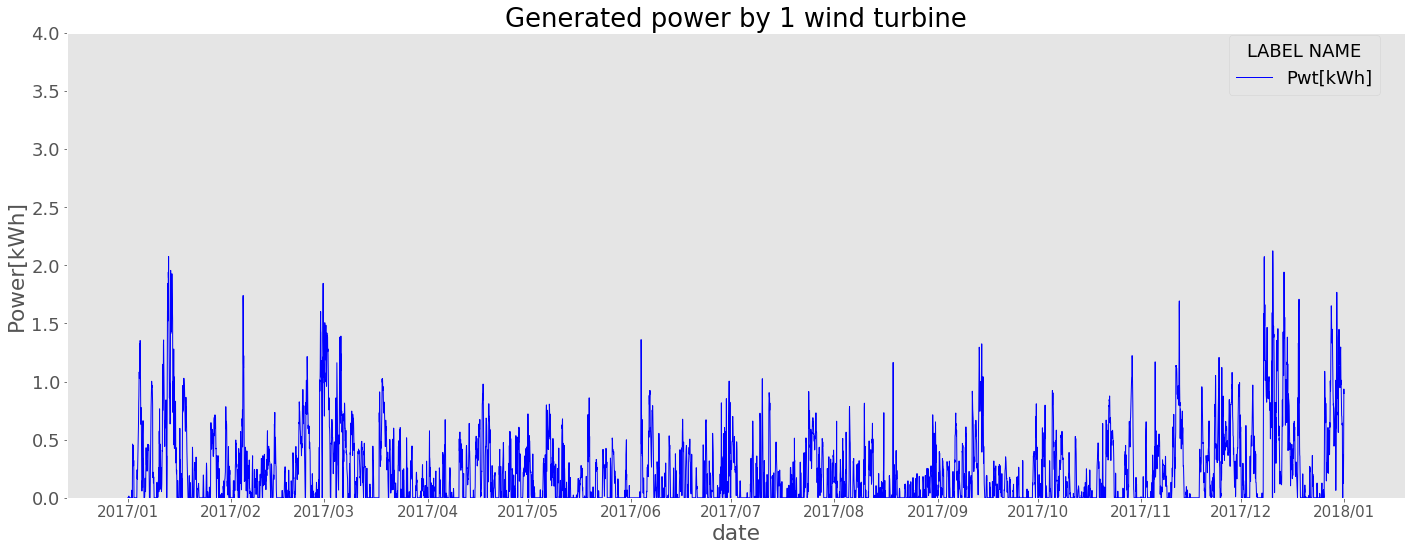

In [6]:
rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18


input1 = input_data['Time']
output1 = input_data['Pwt[kW]']
output2 = input_data['Wind Speed('+str(H)+')[m/s]']

fig = plt.figure(figsize=(50,20))
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(input1, output1, color='blue',linestyle='solid', linewidth = 1, label='Pwt[kWh]')

ax1.set_ylim([0, 4])
#ax2 = ax1.twinx()
#ax2.plot(input1, output2, color='green', linewidth = 1, label='Wind Speed('+str(H)+')[m/s]')
ax1.set_title('Generated power by 1 wind turbine')
ax1.set_xlabel('date')
ax1.set_ylabel('Power[kWh]')
ax1.set_xticklabels(input1,rotation=0, size="small")
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


days      = mdates.MonthLocator()  # every day
#daysFmt = mdates.DateFormatter('%Y-%m-%d')
daysFmt = mdates.DateFormatter('%Y/%m')
ax1.xaxis.set_major_locator(days)
ax1.xaxis.set_major_formatter(daysFmt)

#ax2.set_ylabel('Wind Speed('+str(H)+')[m/s]')
#ax2.set_ylim([0, 25])


# 凡例をまとめて出力する
fig.legend(loc="upper right", 
           borderaxespad=2.0,
           ncol=1,
           title="LABEL NAME"
          ) 

ax1.grid(False) #目盛のごちゃごちゃ変更

fig.show()

<Figure size 20000x8000 with 0 Axes>

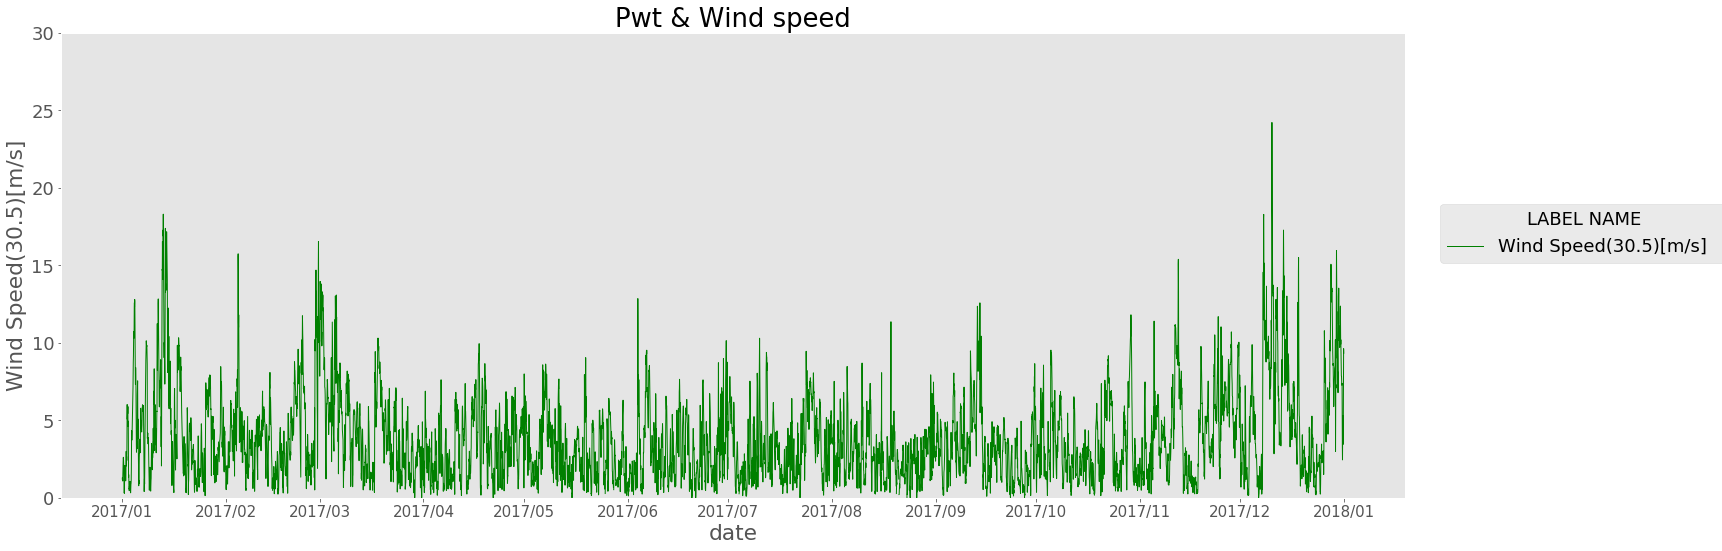

In [7]:
rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18


input1 = input_data['Time']
output1 = input_data['Wind Speed('+str(H)+')[m/s]']

fig = plt.figure(figsize=(50,20),dpi=400)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(input1, output1, color='green',linestyle='solid', linewidth = 1, label='Wind Speed('+str(H)+')[m/s]')

ax1.set_ylim([0, 30])
#ax2 = ax1.twinx()
#ax2.plot(input1, output2, color='green', linewidth = 1, label='Wind Speed('+str(H)+')[m/s]')
ax1.set_title('Pwt & Wind speed')
ax1.set_xlabel('date')
ax1.set_ylabel('Wind Speed('+str(H)+')[m/s]')
ax1.set_xticklabels(input1,rotation=0, size="small")
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


days      = mdates.MonthLocator()  # every day
#daysFmt = mdates.DateFormatter('%Y-%m-%d')
daysFmt = mdates.DateFormatter('%Y/%m')
ax1.xaxis.set_major_locator(days)
ax1.xaxis.set_major_formatter(daysFmt)

#ax2.set_ylabel('Wind Speed('+str(H)+')[m/s]')
#ax2.set_ylim([0, 25])


# 凡例をまとめて出力する
fig.legend(loc="lower right",
           bbox_to_anchor=(1, 0.5, 0.2, .100), 
           borderaxespad=0.,
           ncol=1,
           mode="expand",
           title="LABEL NAME"
          ) 

ax1.grid(False) #目盛のごちゃごちゃ変更

fig.show()